# Installing and Defining Libraries

In [ ]:
# Libraries to be Installed
# !pip install -Uqq fastbook
# !pip install tensorflow opencv-python-headless

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 37.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 37.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 60.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 32.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 68.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 42.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 29.5 MB/s eta 0:00:00


In [1]:
# Libraries needed for Preprocessing of the data.
import os
import cv2
import glob
import numpy as np
from PIL import Image, ImageFilter
# from google.colab import drive
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Libraries needed to train and test the model.
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import RMSprop
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold
import pandas as pd
import shutil
import pickle

%matplotlib inline

# Libraries for Resnet50
# import fastbook
# fastbook.setup_book()
# from fastbook import *
# from fastai.vision.all import *

# Connecting Drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


# Pre-Processing

## Image Embossing

In [2]:
def emboss_image(input_image):
    kernel = np.array([[-2, -1, 0],
                       [-1, 1, 1],
                       [0, 1, 2]])
    embossed_image = cv2.filter2D(input_image, -1, kernel)
    return embossed_image

In [3]:
target_width = 600
target_height = 600

In [4]:
#input_directory = '/content/gdrive/MyDrive/My_Files/MiniProject/Kidney_Stone_Identification/Dataset/combined_data'
input_directory = 'D:\Sastra\MiniProject\Kidney_Stone_Identification\Dataset\combined_data'
#output_directory = '/content/gdrive/MyDrive/My_Files/MiniProject/Kidney_Stone_Identification/Output/Preprocessed_Data_Output/Embossed_Images'
output_directory = 'D:\Sastra\MiniProject\Kidney_Stone_Identification\Output\Preprocessed_Output\Embossed_Images'

In [5]:
for filename in os.listdir(input_directory):
    image_path = os.path.join(input_directory, filename)

    image = cv2.imread(image_path)

    if image is not None:
        embossed_image = emboss_image(image)

        # Resize the embossed image to the target dimensions
        resized_image = cv2.resize(embossed_image, (target_width, target_height))

        output_path = os.path.join(output_directory, filename)

        cv2.imwrite(output_path, resized_image)

print("Embossing and resizing complete. Images saved to", output_directory)

Embossing and resizing complete. Images saved to D:\Sastra\MiniProject\Kidney_Stone_Identification\Output\Preprocessed_Output\Embossed_Images


## Identifying Region of Interest

In [6]:
def crop_coords(img):
    # Otsu's thresholding after Gaussian filtering
    blur = cv2.GaussianBlur(img, (5, 5), 0)
    _, kidney_stone_mask = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    cnts, _ = cv2.findContours(kidney_stone_mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnt = max(cnts, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(cnt)
    return (x, y, w, h)

In [7]:
def truncation_normalization(img):
    Pmin = np.percentile(img[img != 0], 5)
    Pmax = np.percentile(img[img != 0], 99)
    truncated = np.clip(img, Pmin, Pmax)
    normalized = (truncated - Pmin) / (Pmax - Pmin)
    normalized[img == 0] = 0
    return normalized

In [8]:
def clahe(img, clip):
    clahe = cv2.createCLAHE(clipLimit=clip)
    cl = clahe.apply(np.array(img * 255, dtype=np.uint8))
    return cl

In [9]:
input_images = os.listdir("D:\Sastra\MiniProject\Kidney_Stone_Identification\Output\Preprocessed_Output\Embossed_Images")

In [10]:
all_images = []
for i in input_images:
    all_images.append(os.path.join("D:\Sastra\MiniProject\Kidney_Stone_Identification\Output\Preprocessed_Output\Embossed_Images",i))

In [11]:
images = []
for img in all_images:
    img = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (600,600 ))
    (x, y, w, h) = crop_coords(img)
    # Create a Rectangle patch
    rect = patches.Rectangle((x, y), 550, 335, linewidth=1, edgecolor='r', facecolor='none')
    # Add the patch to the Axes
    img_cropped = img[y:y+300, x:x+w]
    images.append(img_cropped)

### Temporary Output for Identification of Region of Interest

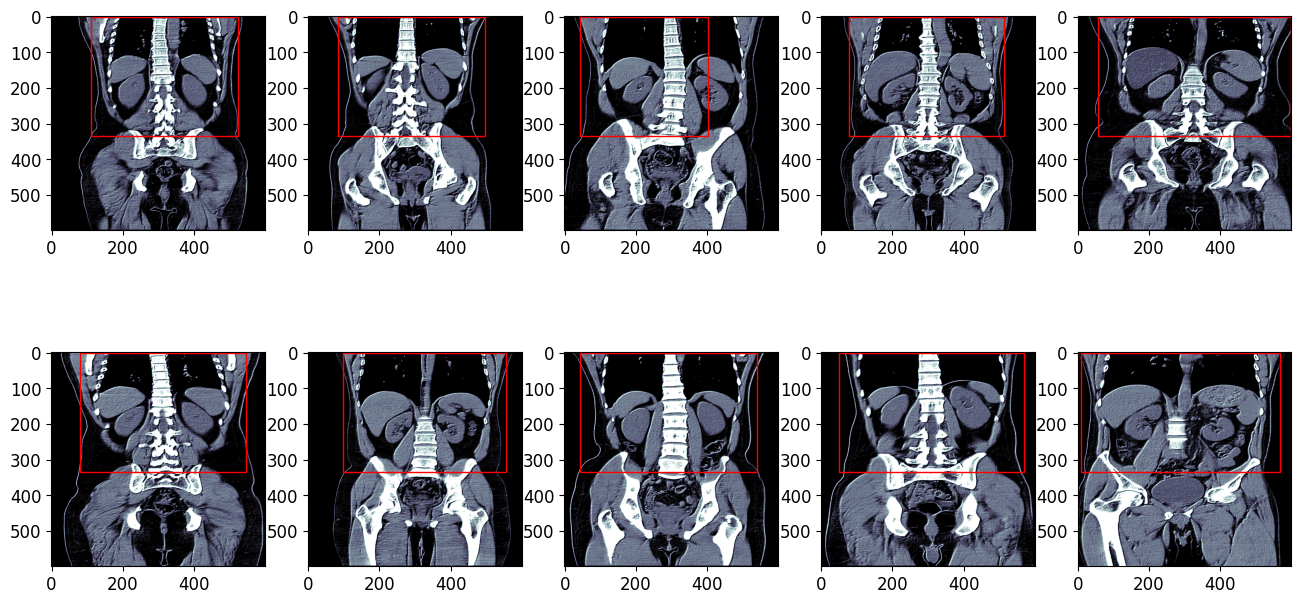

In [ ]:
_, axs = plt.subplots(2, 5, figsize=(16, 8))
axs = axs.flatten()
temp_images = []
for img, ax in zip(all_images, axs):
    img = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (600,600 ))
    (x, y, w, h) = crop_coords(img)
    # Create a Rectangle patch
    rect = patches.Rectangle((x, y), w, 335, linewidth=1, edgecolor='r', facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(rect)
    img_cropped = img[y:y+335, x:x+w]
    images.append(img_cropped)
    ax.imshow(img, cmap="bone")

plt.savefig("rectangles.png")
plt.show()

## Cropping the Region of Interest

In [12]:
dest = "D:\Sastra\MiniProject\Kidney_Stone_Identification\Output\Preprocessed_Output\Region_of_Interest_Images"

In [13]:
# _, axs = plt.subplots(2, 5, figsize=(16, 8))
# axs = axs.flatten()
final_imgs = []
IMG_SIZE = 512
for img_cropped in images:
    img_normalized = truncation_normalization(img_cropped)
    # Enhancing the contrast of the image.
    cl1 = clahe(img_normalized, 1.0)
    cl2 = clahe(img_normalized, 2.0)
    img_final = cv2.merge((np.array(img_normalized*255, dtype=np.uint8),cl1,cl2))
    # Resize the image to the final shape.
    img_final = cv2.resize(img_final, (IMG_SIZE, IMG_SIZE))
    # ax.imshow(img_final)
    final_imgs.append(img_final)
# plt.savefig("final_imgs.png")
# plt.show()

In [14]:
for i,j in zip(final_imgs, input_images):
  image_pil = Image.fromarray(i)
  image_pil.save(os.path.join(dest, j))

## Augmentation of Images

In [2]:
idg = ImageDataGenerator(rescale=1./255) #, rotation_range=30, horizontal_flip=True, shear_range=0.3, zoom_range=0.3

# Model Training and Comparision

## Deep Kronecker Network

In [3]:
def create_model():
  model = Sequential([
      Conv2D(64, (3, 3), activation='relu', input_shape=(128, 128,3)),
      MaxPooling2D((4, 4)),
      Conv2D(64, (3, 3), activation='relu', trainable=False),
      MaxPooling2D((4, 4)),
      Conv2D(64, (3, 3), activation='relu', trainable=False),
      MaxPooling2D((4, 4)),
      Flatten(),
      Dense(1656, activation='relu'),
      Dropout(0.2),
      Dense(94),
      Dense(2, activation='softmax')
  ])
  return model

In [4]:
#dest = "/content/drive/MyDrive/My_Files/MiniProject/Kidney_Stone_Identification/Output/Preprocessed_Data_Output/Region_of_Interest_Images"
dest = "D:\Sastra\MiniProject\Kidney_Stone_Identification\Output\Preprocessed_Output\Region_of_Interest_Images"
#dest = "/content/drive/MyDrive/My_Files/MiniProject/Kidney_Stone_Identification/Dataset/combined_data"

In [5]:
cross_img = tf.keras.preprocessing.image.ImageDataGenerator()
#comp_data = "/content/drive/MyDrive/My_Files/MiniProject/Kidney_Stone_Identification/Dataset/combined_imgs"
comp_data = "D:\Sastra\MiniProject\Kidney_Stone_Identification\Dataset\combined_imgs"
train_generator = cross_img.flow_from_directory(comp_data, class_mode="categorical", target_size=(128,128), batch_size=16)

Found 1799 images belonging to 2 classes.


In [22]:
# data = pd.DataFrame()
# data[['images', 'label']] = [os.listdir(os.path.join(comp_data, 'Normal')), 'Normal']

In [6]:
comp_data = 'D:\Sastra\MiniProject\Kidney_Stone_Identification\Dataset\combined_imgs'
data = pd.DataFrame()
data['images'] = [os.path.join(comp_data, 'Normal', file) for file in os.listdir(os.path.join(comp_data, 'Normal'))]
data['label'] = 'Normal'

In [66]:
# data_kidney = pd.DataFrame()
# data_kidney[['images', 'label']] = [os.listdir(os.path.join(comp_data, 'Kidney_stone')), 'Kidney_stone']

In [7]:
comp_data = 'D:\Sastra\MiniProject\Kidney_Stone_Identification\Dataset\combined_imgs'
data_kidney = pd.DataFrame()
data_kidney['images'] = [os.path.join(comp_data, 'Kidney_stone', file) for file in os.listdir(os.path.join(comp_data, 'Kidney_stone'))]
data_kidney['label'] = 'Kidney_stone'

In [8]:
data = pd.concat([data, data_kidney], axis=0)
data.shape

(1799, 2)

In [61]:
# processed=os.listdir(dest)
# for i in data['images']:
#   if i not in processed:
#     ind = data[data["images"] ==i].index.values.astype(int)[0]
#     data=data.drop(ind)
#     print(ind)

# processed = os.listdir(dest)
# indices_to_drop = []
# for i in data['images']:
#     if i not in processed:
#         ind = data[data["images"] == i].index
#         #if not ind.empty:
#         indices_to_drop.append(ind[0])
# data = data.drop(indices_to_drop)

In [62]:
# data=data.reset_index()
# data = data.reset_index(drop=True)

In [63]:
# y=list(data['label'])
# counter ={
#     'Normal':0,
#     'Kidney_stone':0
# }
# imgs = []
# labels = []
# for i in range(len(y)):
#   if counter[y[i]]<790:
#     imgs.append(data['images'][i])
#     labels.append(y[i])
#     counter[y[i]]+=1
# data_cleaned = pd.DataFrame()
# data_cleaned['images'] = imgs
# data_cleaned['label'] = labels

# downsampling_ratio = 790
# data = data.sample(frac=1, random_state=42)
# counter = {
#     'Normal': 0,
#     'Kidney_stone': 0
# }

# imgs = []
# labels = []

# for i in range(len(data)):
#     label = data['label'][i]
#     if counter[label] < downsampling_ratio:
#         imgs.append(data['images'][i])
#         labels.append(label)
#         counter[label] += 1

# data_cleaned = pd.DataFrame()
# data_cleaned['images'] = imgs
# data_cleaned['label'] = labels

In [69]:
# data_cleaned.shape

(0, 2)

In [9]:
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [21]:
# data_cleaned.head()

In [12]:
#for train_index, val_index in kfold.split(np.zeros(data_cleaned.shape[0]),data_cleaned[['label']]):
for train_index, val_index in kfold.split(np.zeros(data.shape[0]),data[['label']]):
  training_data = data #.iloc[train_index] #data_cleaned
  validation_data = data.iloc[val_index] #data_cleaned.iloc[val_index]
  image_dir = dest
  train_data_generator = idg.flow_from_dataframe(training_data, directory = image_dir,
                    x_col = "images", y_col = "label",
                    class_mode = "categorical", shuffle = True, target_size=(128, 128), batch_size=16)
  valid_data_generator  = idg.flow_from_dataframe(validation_data, directory = image_dir,
              x_col = "images", y_col = "label",
              class_mode = "categorical", shuffle=False, target_size=(128, 128), batch_size=16)
  model = create_model()
  custom_optimizer = RMSprop(learning_rate=0.001)
  model.compile(optimizer=custom_optimizer,loss='binary_crossentropy',metrics=['accuracy'])
  model.fit(train_data_generator,epochs=150, validation_data = valid_data_generator)
  y_pred = model.predict(valid_data_generator)
  preds=[]
  for i in y_pred:
    preds.append(np.argmax(i, axis=0))
  print(classification_report(valid_data_generator.classes, preds))

Found 1799 validated image filenames belonging to 2 classes.
Found 180 validated image filenames belonging to 2 classes.
Epoch 1/150
  9/113 [=>............................] - ETA: 1:30 - loss: 0.6932 - accuracy: 0.5139

KeyboardInterrupt: 

###**Convolutional Neural Network**

In [ ]:
input_shape = (335, 550, 1)
batch_size = 32
epochs = 20
initial_learning_rate = 0.0001
validation_split = 0.1

In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=validation_split)

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='binary',
    subset='training')

In [ ]:
validation_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='binary',
    subset='validation')

In [ ]:
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='binary')

In [ ]:
custom_optimizer = RMSprop(learning_rate=initial_learning_rate)
model.compile(optimizer=custom_optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_generator, epochs=epochs, validation_data=validation_generator)

In [ ]:
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test accuracy: {test_acc}')

In [ ]:
y_pred = (model.predict(test_generator) > 0.5).astype(int)

In [ ]:
print(classification_report(test_generator.classes, y_pred))
conf_matrix = confusion_matrix(test_generator.classes, y_pred)
print(f'Confusion Matrix:\n{conf_matrix}')

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

In [ ]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

###**ResNet50 Convolutional Neural Network Model**

In [ ]:
path = Path('/content/gdrive/My Drive/Deep/Stone/')

In [ ]:
train_fnames = get_image_files(path/"Train")

In [ ]:
augs = [RandomResizedCropGPU(size=224, min_scale=0.75), Rotate(), Zoom()]
dblock = DataBlock(blocks=(ImageBlock(cls=PILImage), CategoryBlock),
                   splitter=RandomSplitter(valid_pct=0.2, seed=23),
                   get_y=parent_label,
                   item_tfms=Resize(512, method="squish"),
                   batch_tfms=augs,
                   )

dls = dblock.dataloaders(train_fnames)

In [ ]:
# print number of classes and length of train and valid datasets
dls.c, len(dls.train_ds), len(dls.valid_ds)

In [ ]:
dls.vocab

In [ ]:
dls.show_batch()

In [ ]:
model = nn.Sequential(create_body(xresnet50, pretrained=False),create_head(nf=2048, n_out=2))
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy)

In [ ]:
learn.fit_one_cycle(40,1e-2)

In [ ]:
learn.save(path/'kidney-50')

In [ ]:
learn.recorder.plot_loss(skip_start=0, with_valid=True)

In [ ]:
#test_items = get_image_files(path/"Test")
all_files= get_image_files(path)

#####**Evaluating Model Performance**

In [ ]:
augs = [RandomResizedCropGPU(size=224, min_scale=0.75), Rotate(), Zoom()]
dblock = DataBlock(blocks=(ImageBlock(cls=PILImage), CategoryBlock),
                   splitter=GrandparentSplitter(train_name='Train', valid_name='Test'),
                   get_y=parent_label,
                   item_tfms=Resize(512, method="squish"),
                   batch_tfms=augs,
                   )

dls_test = dblock.dataloaders(all_files)


In [ ]:
print("Number of examples in testing:", len(dls_test.valid_ds))

In [ ]:
model = nn.Sequential(create_body(xresnet50, pretrained=False),create_head(nf=2048, n_out=2))

In [ ]:
learn1 = learn1 = Learner(dls_test, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy).load()

In [ ]:
interp = ClassificationInterpretation.from_learner(learn1)
interp.plot_confusion_matrix()

In [ ]:
interp.print_classification_report()

###**Lenet Network Architecture**

In [ ]:
def build_lenet(input_shape):
  # Define Sequential Model
  model = tf.keras.Sequential()

  # C1 Convolution Layer
  model.add(tf.keras.layers.Conv2D(filters=6, strides=(1,1), kernel_size=(5,5), activation='relu', input_shape=(128,128,3)))

  # S2 SubSampling Layer
  model.add(tf.keras.layers.AveragePooling2D(pool_size=(2,2), strides=(2,2)))

  # C3 Convolution Layer
  model.add(tf.keras.layers.Conv2D(filters=6, strides=(1,1), kernel_size=(5,5), activation='relu'))

  # S4 SubSampling Layer
  model.add(tf.keras.layers.AveragePooling2D(pool_size=(2,2), strides=(2,2)))

  # C5 Fully Connected Layer
  model.add(tf.keras.layers.Dense(units=120, activation='relu'))

  # Flatten the output so that we can connect it with the fully connected layers by converting it into a 1D Array
  model.add(tf.keras.layers.Flatten())

  # FC6 Fully Connected Layers
  model.add(tf.keras.layers.Dense(units=84, activation='relu'))

  # Output Layer
  model.add(tf.keras.layers.Dense(units=2, activation='softmax'))

  # Compile the Model
  # model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.SGD(lr=0.1, momentum=0.0, decay=0.0), metrics=['accuracy'])

  return model